In [40]:
#  Thresholds for "knobs" QC

MAX_MEAN = 1e9 #165
MAX_SDEV = 1e9 #0.4
MAX_BLOTSIZE = 1e9 #30000
MIN_VASCULATURE = 4 #0.1*correction_factor
MAX_LIGHTBLOTSIZE= 1e9 #33

In [2]:
# IMPORTS

import sys,os, glob
import numpy as np
import pandas as pd

from shutil import copyfile

import cv2
from matplotlib import pyplot as plt

In [3]:
# FOLDERS

RAWDIR   = "/HDD/data/UKBB/fundus/raw/CLRIS/"
LWNETDIR = "/HDD/data/UKBB/fundus/lwnet/"
INDEXDIR = "/HDD/data/UKBB/fundus/qcIndexFiles/"

In [4]:
# CONFIGS

MASK_RADIUS=660 # works for UKBB images
RESIZE_RADIUS=500 # normalization factor to standardize images at size
BLOT_THRESHOLD=0.12 # what luminosity will be a blot
LIGHT_BLOT_THRESHOLD=0.95
DILATION_SIZE = 1 # in case one wants to dilate the raw blot -> set larger than 1

h,w=(1536, 2048)

correction_factor = h*w / (MASK_RADIUS**2 * np.pi) / 255 * 3 * 100
# A correction factor because LWNET vessel fraction was computed on full canvas, and in MATLAB
# h*w                      : canvas size
# (MASK_RADIUS**2 * np.pi) : mask area
# /255                     : in MATLAB, intensity goes from 0 to 255, but we want 0-1
# *3                       : lwnet is either R or B, meaning max 1/3 grayscale pixel intensity. we correct for that
# *100                     : percent

In [357]:
explore_df = imgs[imgs['diabetic'] == True]

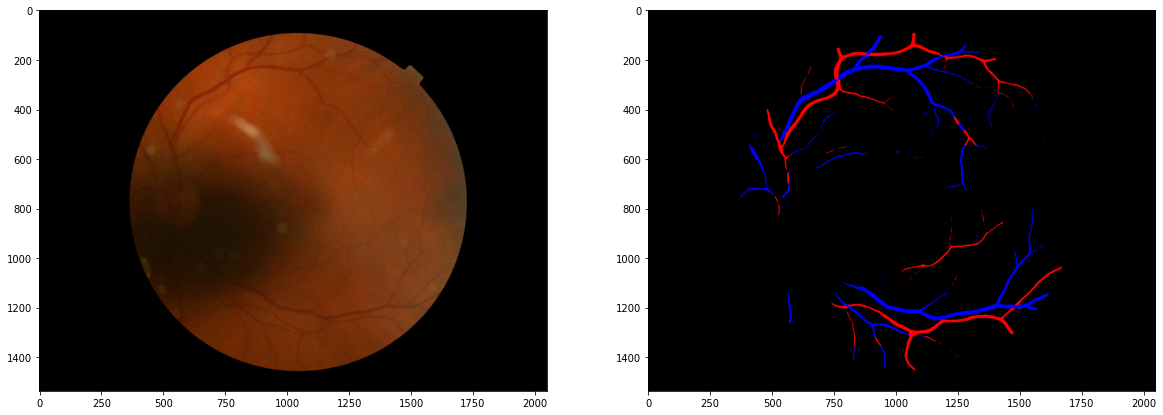

In [375]:
i=i+15
fileinfo(explore_df.index[i])

In [348]:
# FUNCTIONS   

def keep_throw(df,col,threshold, lower=True):

  if lower == True:
    return (df[df[col] <= threshold], df[df[col] > threshold])
  else:
    return (df[df[col] >= threshold], df[df[col] < threshold])

def n_participants(files):
  return len(set([i.split("_")[0] for i in files]))

def fileinfo(file):
    
    f,(ax1,ax2) = plt.subplots(1,2,figsize=[20,20])
    img=plt.imread(RAWDIR+file)
    ax1.imshow(img)

    try:
        img=plt.imread(LWNETDIR+file)
        ax2.imshow(img)
    except:
        pass
#     print(stats.loc[file])

def cp_content(src,dst,files,lwnet=True):

  rmfiles = glob.glob(dst+'*')
  for f in rmfiles:
    os.remove(f)

  for i in files:
    copyfile(src+i, dst+i)
    if lwnet==True:
      try:
        copyfile(LWNETDIR+i, dst+i.split(".png")[0]+"_seg.png")
      except:
        pass

def compare_image(image1, image2):
  plt.figure(figsize=(9,9))
  plt.subplot(1,2,1)
  plt.imshow(image1)
  plt.title('Orignal')
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(image2)
  plt.title('Modified')
  plt.axis('off')

  plt.tight_layout()

def mask_image(img, toGray=False):
  hh,ww=img.shape[:2]
  #print(hh//2,ww//2)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  mask = np.zeros_like(gray)
  mask = cv2.circle(mask, (ww//2,hh//2), RESIZE_RADIUS, (255,255,255), -1)
  #mask = np.invert(mask.astype(bool))

  #result = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
  #result[:, :] = mask[:,:]
#  result[:, :, 3] = mask[:,:,0]
  #plt.imshow(result)
  
  if toGray == True:
    return np.ma.array(gray, mask=np.invert(mask.astype(bool)))
  else:
    return np.ma.array(img, mask=np.invert(mask.astype(bool)))

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img)

def blot_size(img, lightBlot=False):

  if lightBlot==True:
    thresh=LIGHT_BLOT_THRESHOLD
  else:
    thresh=BLOT_THRESHOLD

  gray = mask_image(img, toGray=True)
  #gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
  nGray = gray.copy()
  #quantile = np.quantile(gray[gray.mask==False], BLOT_QUANTILE)
  #print(quantile)

  #nGray[nGray == 0] = 1
  #plt.hist(nGray)
  nGray[nGray.mask == True] = 1

  if lightBlot==False:
    nGray[(nGray<thresh) & (nGray.mask == False)] = 0
  else:
    nGray[(nGray>thresh) & (gray.mask == False)] = 0
    plt.imshow(nGray)

  kernel = np.ones((DILATION_SIZE, DILATION_SIZE), 'uint8')
  dilate_img = cv2.erode(nGray, kernel, iterations=1)
  view = dilate_img.copy()
  view[view==0] = 0.8


  #nGray[nGray==0] = 1
  #compare_image(img,view)

  #binary = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_BINARY)[1]
  binary = (dilate_img > 0).astype(np.uint8)
  binary = 1-binary
  connectivity = 4
  num_labels,labels,surfaceStats,centroids = cv2.connectedComponentsWithStats(binary, connectivity, cv2.CV_32S)
  imshow_components(labels)
  try:
    if lightBlot==False:
      return np.max(surfaceStats[1:,4])
    else:
      print(surfaceStats, '\n\n')
      return np.max(surfaceStats[2:,4])
  except:
    return 0

def getMeanAgeAndStat(pool_in):
    participant = pool_in[0]
    stat = pool_in[1]
    
    idxs = [i for i in ageAndStats.index if participant in i]
    
    return np.nanmean(ageAndStats.loc[idxs, 'age']), np.nanmean(ageAndStats.loc[idxs, stat])

In [33]:
# Image-based QC sats

stats = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/newQC_rawStats.csv", index_col=0)
stats.set_index("file", inplace=True)
stats.index.rename('image', inplace=True)
stats.sort_index(inplace=True)

# adding PBV stat
lwnetMean = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/lwnetmean.csv", header=None)
lwnetMean.columns = ['image', 'mean']
lwnetMean = lwnetMean.set_index('image')
stats['PBV'] = lwnetMean['mean'].loc[stats.index] * correction_factor

# corresponding image info
imgs = pd.DataFrame({'image':stats.index,\
                     'instance':[i.split("_")[2] for i in stats.index],\
                     'eid':[i.split("_")[0] for i in stats.index]})
imgs.set_index('image', inplace=True)

In [283]:
# Participant labels

from datetime import datetime

labels = pd.read_csv("/HDD/data/UKBB/labels/1_data_extraction/ukb34181.csv",\
                     index_col='eid',\
                     usecols=['eid', '31-0.0', '34-0.0', "53-0.0","53-1.0","53-2.0", "54-0.0","54-1.0","54-2.0", '2976-0.0','2976-1.0','2976-2.0','3894-0.0','3894-1.0','3894-2.0','4056-0.0','4056-1.0','4056-2.0', '21003-0.0', '21003-1.0', '21003-2.0'])
labels.columns = ['sex', 'year of birth', 'doa0', 'doa1', 'doa2', 'ac0', 'ac1', 'ac2', 'add0', 'add1', 'add2', 'ahad0','ahad1','ahad2','asd0','asd1','asd2','aa0', 'aa1', 'aa2']
labels['age diabetes diagnosed'] = labels[['add0', 'add1', 'add2']].mean(axis=1)
labels['age heart attack diagnosed'] = labels[['ahad0', 'ahad1', 'ahad2']].mean(axis=1)
labels['age stroke diagnosed'] = labels[['asd0', 'asd1', 'asd2']].mean(axis=1)
# doa: date of attendance
# ac:  assessment center
# aa:  age when attended assessment centre
labels.index = [str(i) for i in labels.index]

# adding assessment center and age when image taken
imgs['ac'] = [ str(labels.loc[ imgs['eid'].iloc[i], 'ac' + imgs['instance'].iloc[i] ]) for i in range(0,len(imgs)) ]
ac_dict = {'11020':'Croydon AC', '11024.0':'Cheadle Repeat AC',\
           '11021':'Birmingham AC', '11014':'Sheffield AC', '11018':'Hounslow AC',\
           '11016':'Liverpool AC', '11022':'Swansea Mobile AC'}
imgs.replace({"ac":ac_dict}, inplace=True)
imgs['age'] = [ labels.loc[ imgs['eid'].iloc[i], 'aa' + imgs['instance'].iloc[i] ] for i in range(0,len(imgs)) ]
imgs['doa'] = [ labels.loc[ imgs['eid'].iloc[i], 'doa' + imgs['instance'].iloc[i] ] for i in range(0,len(imgs)) ]
imgs['doa'] = [datetime.strptime(i, '%Y-%m-%d') for i in imgs['doa']]
imgs['year of birth'] = [ labels.loc[ imgs['eid'].iloc[i], 'year of birth' ] for i in range(0,len(imgs)) ]
imgs['diabetic'] = [ ~np.isnan(labels.loc[i, 'age diabetes diagnosed']) for i in imgs['eid'] ]

# Following code is not needed anymore as I found out that UKBB has a field describing age when coming in.
# This might be more precise as they might have the true birth date of participants

# # adding a correct participant age for each image taken
# # uses column 53, the date of attendance
# # subtracts birth year, using July 2 - the middle of the year - as assumed birthdate

# # Good to know:
# # datetime.strptime can convert str to datetime objects
# # datetime subtraction results in timedelta object, which has days attribute, from where can compute age

# # imgs['doa'] = [ str(labels.loc[ imgs['eid'].iloc[i], 'doa' + imgs['instance'].iloc[i] ]) for i in range(0,len(imgs)) ]
# from datetime import datetime
# imgs['age'] = [ np.float((datetime.strptime(imgs['doa'].iloc[i], '%Y-%m-%d')\
#  - datetime(labels.loc[ imgs['eid'].iloc[i], 'year of birth'], 7, 3) ).days) / 365.25\
#  for i in range(0,len(imgs)) ]

In [8]:
# Knobs QC filtering procedure

print("RAW IMAGES", stats.shape[0])

throw_bright = stats[stats['mean'] > MAX_MEAN]
keep_bright = stats[stats['mean'] <= MAX_MEAN]
print('too bright',throw_bright.shape[0])
keep_sdev, throw_sdev = keep_throw(keep_bright, 'sdev', MAX_SDEV)
print('too high SD',throw_sdev.shape[0])
keep_blots, throw_blots = keep_throw(keep_sdev, 'blot_size', MAX_BLOTSIZE)
print('too much blot',throw_blots.shape[0])

keep_vasculature, throw_vasculature = keep_throw(keep_blots, 'PBV', MIN_VASCULATURE, lower=False)
print('too few lwnet vasculature',throw_vasculature.shape[0])

keep, throw_lightblots = keep_throw(keep_vasculature, 'light_blot_size', MAX_LIGHTBLOTSIZE, lower=True)
print('too much light blot',throw_lightblots.shape[0])

#remove double images for same visit
# double_imgs=[]
# for i in keep.index:
#     if i.split("_")[3] == "1.png":
#         first_img = i.split("_1.png")[0]+"_0.png"
#         if first_img in keep.index:
#             double_imgs.append(first_img)

# keep=keep.drop(double_imgs)


# print("# double images removed",len(double_imgs))

keep_parts=set([i.split("_")[0] for i in keep.index])
keep_files = set(keep.index)

print("REMAINING images", keep.shape[0])

RAW IMAGES 173814
too bright 0
too high SD 0
too much blot 0
too few lwnet vasculature 42769
too much light blot 0
REMAINING images 129193


In [9]:
# Mattia's QC vs new knobs QC

mattiaQC = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/mattiaQC_participants.txt", header=None, names=['participants'], dtype=str)
mattiaQC_parts = set(mattiaQC['participants'])

mattiaQC = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/mattiaQC_images.txt", header=None, names=['files'], dtype=str)
mattiaQC_files = set(mattiaQC['files'])
mattiaQC_files = set([i for i in list(mattiaQC_files) if i in stats.index]) # getting rid of withdrawn participants


only_mattiaQC = mattiaQC_files-keep_files
only_newQC = keep_files-mattiaQC_files
print(len(only_mattiaQC), len(only_newQC))


# cp_content(RAWDIR, "/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/", list(mattiaQC_files)[0:2000])
# cp_content(RAWDIR, "/HDD/data/UKBB/fundus/qcStats/onlyMattiaQC/", list(only_mattiaQC)[0:2000])
# cp_content(RAWDIR, "/HDD/data/UKBB/fundus/qcStats/onlyNewQC/", list(only_newQC)[0:2000])

print('mattiaQC:', len(mattiaQC_parts))
print('newQC:', len(keep_parts))
print('intersect:', len(mattiaQC_parts&keep_parts))

3701 16622
mattiaQC: 65033
newQC: 70407
intersect: 63839


In [10]:
# Max-overlap QC, using LWNET

thresholds = np.quantile(stats['PBV'].loc[stats['PBV'] > 0], np.linspace(1,999, 999)/1000)

intersect=[]
union=[]
overlap=[]
N_i = []
for i,thres in enumerate(thresholds):

    pass_files = set(stats[stats['PBV'] > thres].index)
    N_i.append(len(set([j.split('_')[0] for j in pass_files])))
    intersect.append(pass_files & mattiaQC_files)
    union.append(pass_files | mattiaQC_files)

    overlap.append( len(intersect[i]) / len(union[i]) )

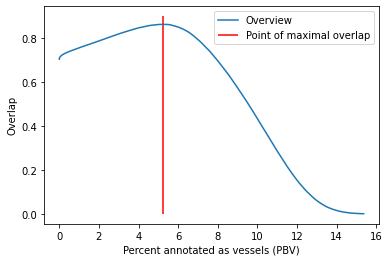

In [11]:
# Finding the maximal overlap between LWNET QC and ARIA QC

imax = np.argmax(overlap)
deciles = np.quantile(stats['PBV'].loc[stats['PBV'] > 0], np.linspace(1,9, 9)/10)

plt.plot(thresholds,overlap)
plt.vlines(thresholds[imax], 0, 0.9, color='r')
# for i in deciles:
#     plt.vlines(i, 0, 0.9, color='g')
plt.xlabel("Percent annotated as vessels (PBV)")
plt.ylabel("Overlap")
plt.legend(["Overview", "Point of maximal overlap"])

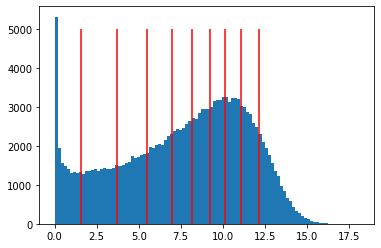

In [12]:
# Deciles of PBV > 0

plt.hist(stats['PBV'].loc[stats['PBV'] > 0], 100)
for i in deciles:
    plt.vlines(i,0,5000, color='red')

In [13]:
# h_SNP of the various QC candidates

qc_results = pd.DataFrame({\
    'N' : [72599,70161,62703,55522,74938,68831,62012,54635,46776,38486,29824,20677,10930,80095,67899,63242,81522],
    'h_SNP Affymetrix' : [np.nan,np.nan,0.3144,0.2748,0.3078,0.3212,0.325,0.2994,0.2726,0.2336,0.2052,0.1318,0.0665,0.2701,0.3216,0.3255,0.2645],\
    'h_SNP Full' : [0.2253,0.2308,0.2446,0.2095,0.2394,0.2558,0.2543,0.2342,0.2029,0.1674,0.1421,0.105,0.0581,0.2174,0.2576,0.2556,0.2123]},\
    index=['Knobs 2','Knobs 3', 'Mattia\'s QC', 'Knobs 1', 'LWNET Decile 1', "LWNET Decile 2", "LWNET Decile 3", "LWNET Decile 4", "LWNET Decile 5","LWNET Decile 6","LWNET Decile 7","LWNET Decile 8","LWNET Decile 9", "LWNET > 0", "LWNET mode", "LWNET max Overlap", "no QC"])

qc_results=qc_results.sort_values("h_SNP Affymetrix", ascending=False)
qc_results['Affymetrix rank'] = list(range(1,len(qc_results)+1))
qc_results=qc_results.sort_values("h_SNP Full", ascending=False)
qc_results['Full rank'] = list(range(1,len(qc_results)+1))

qc_results = qc_results.sort_values("h_SNP Full", ascending=False)

In [284]:
# biases by QC

with open(INDEXDIR+"noQC.txt", 'r') as f:
        tmp=[]
        for line in f:
            tmp.append(line.split("_")[0])
all_participants = set(tmp)

qcs = ["noQC.txt", 'newQC_lwnetEPS.txt', 'newQC_lwnetDecile1.txt', 'knobs2.txt', 'knobs3.txt', 'newQC_lwnetDecile2.txt', 'newQC_lwnetMode_PBV4Percent.txt', 'newQC_maxOverlap.txt', 'mattiaQC.txt', 'newQC_lwnetDecile3.txt', 'newQC_complicatedQC.txt', 'newQC_lwnetDecile4.txt', 'newQC_lwnetDecile5.txt', 'newQC_lwnetDecile7.txt','newQC_lwnetDecile7.txt','newQC_lwnetDecile8.txt','newQC_lwnetDecile9.txt']

qc_participants = []
for qc in qcs:
    with open(INDEXDIR+qc, 'r') as f:
        tmp=[]
        for line in f:
            tmp.append(line.split("_")[0])
    qc_participants.append(set(tmp))

sex_ratios = []
fraction_diabetic = []
fraction_heartAttack = []
fraction_stroke = []
age_diabetes_diagnosed = []
mean_age = []
Ns = []
for i,parts in enumerate(qc_participants):
    Ns.append(len(parts))

    tmp_df = labels.loc[[i for i in list(parts)]]
    tmp_throw = labels.loc[[ i for i in list (all_participants - parts) ]]
    tmp_df['QC'] = qcs[i]
    tmp_throw['QC'] = qcs[i]

    sex_ratios.append(tmp_df['sex'].mean())
    mean_age.append(tmp_df['year of birth'].mean())
    fraction_diabetic.append( 1 - tmp_df['age diabetes diagnosed'].isna().sum() / len(tmp_df) )
    fraction_heartAttack.append( 1 - tmp_df['age heart attack diagnosed'].isna().sum() / len(tmp_df) )
    fraction_stroke.append( 1 - tmp_df['age stroke diagnosed'].isna().sum() / len(tmp_df) )
    age_diabetes_diagnosed.append( tmp_df['age diabetes diagnosed'].mean() )

    if i == 0:
        labels_by_qc = tmp_df
        thrown_labels_by_qc = tmp_throw
        thrown_labels_by_qc = labels.loc[[i for i in list(all_participants)]]
        thrown_labels_by_qc['QC'] = "Base distribution"
        thrown_labels_by_qc = thrown_labels_by_qc.append(tmp_throw)
    else:
        labels_by_qc = labels_by_qc.append(tmp_df)
        thrown_labels_by_qc = thrown_labels_by_qc.append(tmp_throw)

bias_df=qc_results.sort_values("N", ascending=False)
bias_df['sex ratios'] = sex_ratios
bias_df['mean year of birth'] = mean_age
bias_df['fraction diabetic'] = fraction_diabetic
bias_df['fraction heart attack'] = fraction_heartAttack
bias_df['fraction stroke'] = fraction_stroke
bias_df['age diabetes diagnosed'] = age_diabetes_diagnosed
bias_df['N'] = Ns

/SSD/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/SSD/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: Mean of empty slice
/SSD/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: Mean of empty slice
/SSD/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: Mean of empty slice
/SSD/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: Mean of empty slice
/SSD/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: Mean of empty slice
/SSD/home/michael/.local/lib/python3.6/si

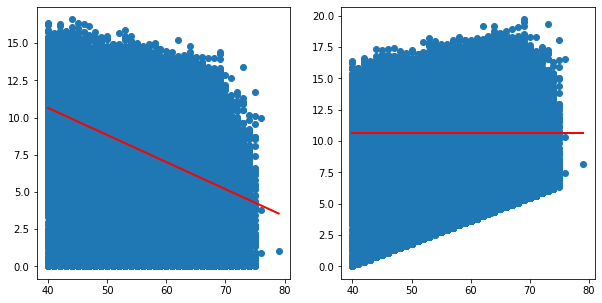

Process ForkPoolWorker-135:
Process ForkPoolWorker-132:
Process ForkPoolWorker-138:
Process ForkPoolWorker-136:
Process ForkPoolWorker-131:
Process ForkPoolWorker-139:
Process ForkPoolWorker-140:
Process ForkPoolWorker-137:
Process ForkPoolWorker-134:
Process ForkPoolWorker-133:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/SSD/home/michael/.local/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/SSD/home/michael/.local/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/SSD/home/michael/.local/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    sel

In [265]:
# age correction

# optional cutoff
# images with PBV < cutoff are thrown out before age correction is performed
cutoff = 0
ageAndStats = stats[stats['PBV'] > cutoff]
ageAndStats['age'] = imgs.loc[ageAndStats.index, 'age']

import scipy

# computing participant-based age and PBV as means of all images and ages when image taken
from multiprocess import Pool
pool = Pool(10)
in_pool = [(i,'PBV') for i in list(all_participants)]
out = pool.map(getMeanAgeAndStat, in_pool);

df_agecorr=pd.DataFrame(out, columns=['age', 'PBV'])
df_agecorr.index = list(all_participants)
df_agecorr.dropna(inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=[10,5])
ax1.scatter(df_agecorr['age'], df_agecorr['PBV']);

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_agecorr['age'],df_agecorr['PBV'])

x = np.arange(40,80)
y = x*slope + intercept
ax1.plot(x,y,'r', linewidth=2)

# age-corrected scatter

df_agecorr['PBV_corrected'] = df_agecorr['PBV'] - ( ( df_agecorr['age'] - 40 ) * slope )
stats['PBV_corrected'] = stats['PBV'] - ( ( imgs['age'] - 40 ) * slope )


ax2.scatter(df_agecorr['age'], df_agecorr['PBV_corrected'])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_agecorr['age'],df_agecorr['PBV_corrected'])

x = np.arange(40,80)
y = x*slope + intercept
ax2.plot(x,y,'r', linewidth=2)

df_agecorr['age_bins'] = pd.qcut( df_agecorr['age'], q=10 )

In [ ]:
# age correction without cutoff

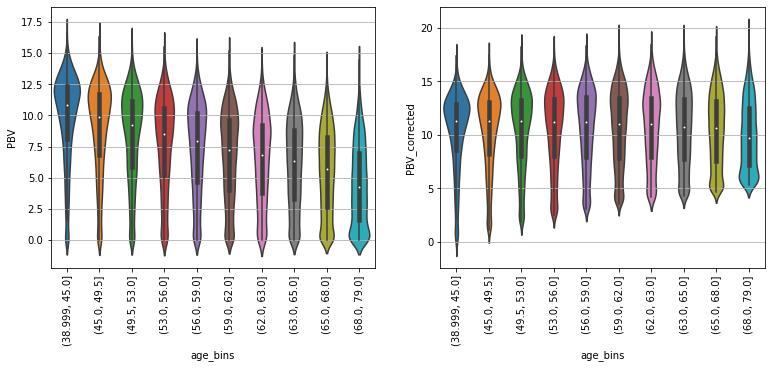

In [116]:
import seaborn as sns

plt.figure(figsize=(12.8,4.8))

plt.subplot(1,2,1)
sns.violinplot(x='age_bins', y='PBV', data=df_agecorr)
plt.grid(axis='y')
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.violinplot(x='age_bins', y='PBV_corrected', data=df_agecorr)
plt.grid(axis='y')
plt.xticks(rotation=90);

In [ ]:
# age correction with 1% cutoff

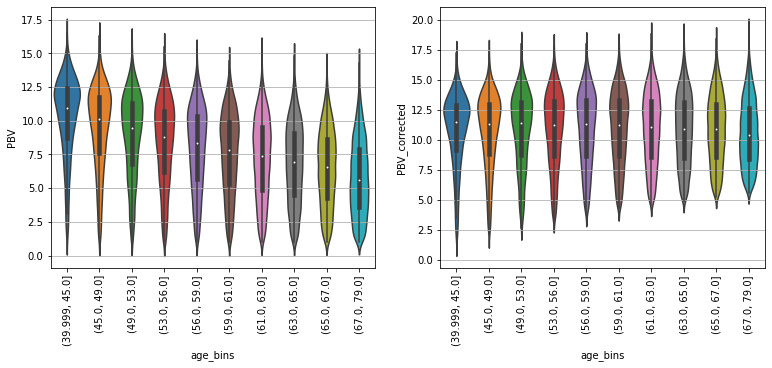

In [235]:
import seaborn as sns

plt.figure(figsize=(12.8,4.8))

plt.subplot(1,2,1)
sns.violinplot(x='age_bins', y='PBV', data=df_agecorr)
plt.grid(axis='y')
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.violinplot(x='age_bins', y='PBV_corrected', data=df_agecorr)
plt.grid(axis='y')
plt.xticks(rotation=90);

In [ ]:
# age correction with 5% cutoff

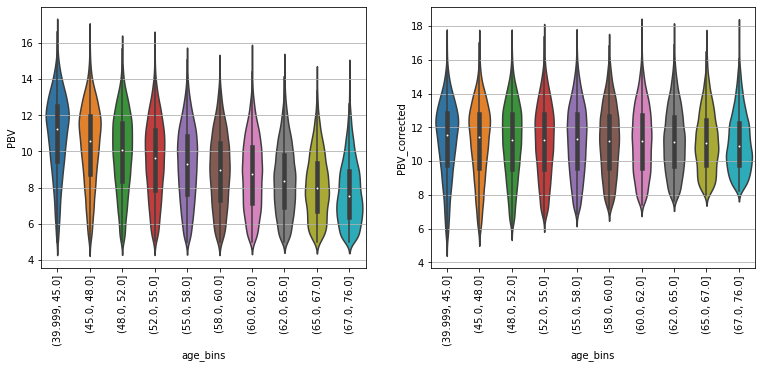

In [233]:
import seaborn as sns

plt.figure(figsize=(12.8,4.8))

plt.subplot(1,2,1)
sns.violinplot(x='age_bins', y='PBV', data=df_agecorr)
plt.grid(axis='y')
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.violinplot(x='age_bins', y='PBV_corrected', data=df_agecorr)
plt.grid(axis='y')
plt.xticks(rotation=90);

In [380]:
ventile4,ventile6

(7.507427998224507, 8.912142719131158)

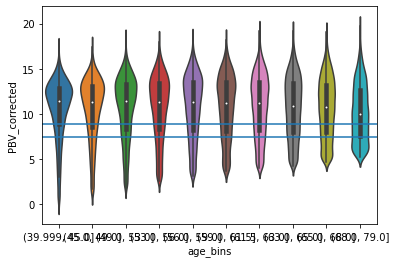

In [381]:
ventile4 = np.quantile(df_agecorr['PBV_corrected'].dropna(), 4/20)
ventile6 = np.quantile(df_agecorr['PBV_corrected'].dropna(), 6/20)

fig=sns.violinplot(x='age_bins', y='PBV_corrected', data=df_agecorr)
fig.axhline(ventile4)
fig.axhline(ventile6)

# Motivation and summary
We are currently relying on ARIA vessel segmentation for quality control of our images. Mattia used two parameters, 1) the number of vessel segments and 2) the total length of all segments, on which he put both lower and upper thresholds.

While these parameters allowed us to reach a heritability of ~0.25 on distance factor tortuosity, and a sample size of around 62000, these thresholds are arbitrary, and may not be overall good quality control of the images.

Therefore, here I present various standard image quality control parameters, as well the output of the neural net L-WNET as alternatives to the old QC, relying on resulting h_SNP on DF tortuosity for making a decision

# Parameters and their thresholds
We have the following parameters now:

| Parameter | Description |
| --- | --- |
| Mean | The mean grayscale luminosity |
| SDEV | The standard deviatio of grayscale luminosity |
| Blotsize | Many images have dark spots due to poor illumination. Using cv2's standard processing function "dilate", computed the area of the largest dark spot in an image, where a dark spot is defined as a dilated area with luminosity below a certain threshold. See `newQC_multiprocess.py` for details.
| Lightblotisze | Same, but with too high luminosity as threshold.
| Vasculature | PBV (percent annotated as blood vessels), a value derived from LWNET output.

After some playing around, I settled with max_mean, max_sdev, max_blotsize, min_vasculature, max_lightblotsize for my standard-parameter QCs, referred to as "knobs" QCs.

# Raw distribution of QC parameters

Number of images: 173814


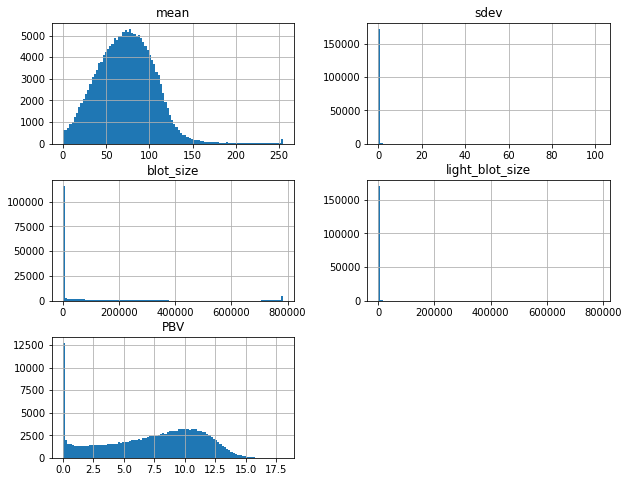

In [82]:
print('Number of images:', len(stats))
f=stats.hist(bins=100, figsize=(10,8))


# Distribution of QC parameters after filtering

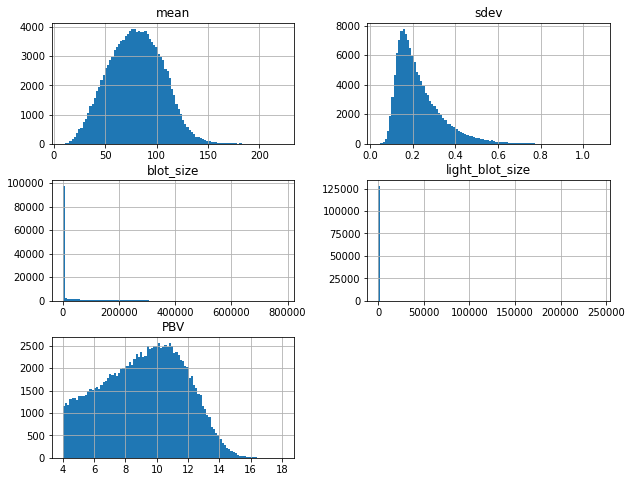

In [85]:
keep.hist(bins=100, figsize=(10,8));

# The different candidates for new QC
Playing around with the various "knobs" and looking at the raw images that are filtered out and kept, I wasn't able to find a clear best candidate. Either the resulting sample size was too small, or I was seeing images of poor quality pass the QC.

Therefore, Sven suggested generating a few QC candidates, and running GWAS with median DF tortuosity for the various candidates, using h_SNP as a judge.


The following is the list of candidates chosen

|Name|Description|
|---|---|
|No QC|Keeping all the images
|Knobs|Three different combinations of standard parameter thresholds, resulting in various Ns (exact parameters in my notebook) (I also use the LWNET a little bit, to remove images with zero vasculature)
|LWNET|Using only PBV as estimated by LWNET for QC

## Results

In [18]:
qc_results

,N,h_SNP Affymetrix,h_SNP Full,Affymetrix rank,Full rank
LWNET mode,67899,0.3216,0.2576,3,1
LWNET Decile 2,68831,0.3212,0.2558,4,2
LWNET max Overlap,63242,0.3255,0.2556,1,3
LWNET Decile 3,62012,0.3250,0.2543,2,4
Mattia's QC,62703,0.3144,0.2446,5,5
LWNET Decile 1,74938,0.3078,0.2394,6,6
LWNET Decile 4,54635,0.2994,0.2342,7,7
Knobs 3,70161,NaN,0.2308,17,8
Knobs 2,72599,NaN,0.2253,16,9
LWNET > 0,80095,0.2701,0.2174,10,10


-> The first take-home message here is that Affymetrix GWAS output results in overestimated h_SNP.

Further, we attain higher h_SNP when using LWNET-based QC as compared to my 'knobs' QCs.

To further see where we should set the threshold, I plotted N against h_SNP:

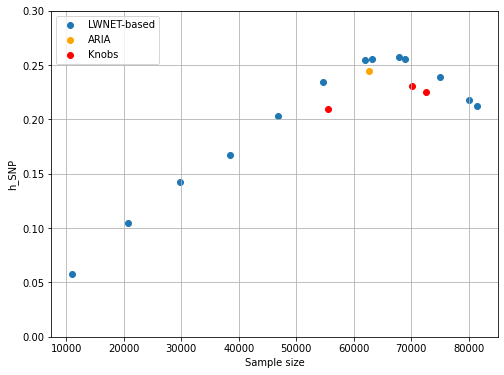

In [186]:
qc_results=qc_results.sort_values("N", ascending=False)
idx_lwnet = [0,1,2,5,6,7,9,11,12,13,14,15,16]
mattia = 8
knobs = [3,4,10]
plt.figure(figsize=(8,6))
# plt.gca().invert_xaxis()
plt.scatter(qc_results['N'].iloc[idx_lwnet],qc_results['h_SNP Full'].iloc[idx_lwnet])
plt.scatter(qc_results['N'].iloc[mattia],qc_results['h_SNP Full'].iloc[mattia], c='orange')
plt.scatter(qc_results['N'].iloc[knobs],qc_results['h_SNP Full'].iloc[knobs], c='red')
plt.ylim([0,0.3])
plt.legend(['LWNET-based', "ARIA", "Knobs"])
plt.xlabel("Sample size")
plt.ylabel("h_SNP")
plt.grid()

**Insights**
1) LWNET QC outperforms all other QCs in terms of h_SNP.

2) N should probably be chosen within [60000, 70000].

**Remaining questions**

1) Bias: Do we disproportionally remove participants with eye diseases or of certain age groups?

For this I will plot age and diabetes distributions as a function of QC.

2) h_SNP optimization: Is it problematic to optimize for h_SNP in our QC framework?

Showing this directly is hard. The h_SNP curve above seems to be dominated by two forces: 1) power (increasing with sample size) 2) noise (also increasing with sample size because more and more images of low quality pass the QC).

# Biases: Age, assessment center

## Age distribution by QC

Text(0.5, 1.0, 'Age distribution of participants with at least one image that passes QC')

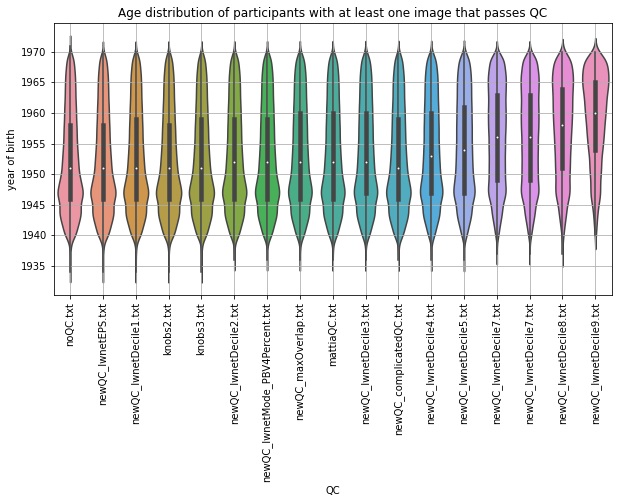

In [183]:
import seaborn as sns

# plot results

plt.figure(figsize=[10,5])
ax = sns.violinplot(x="QC", y="year of birth", data=labels_by_qc, order=qcs);
plt.grid()
plt.xticks(rotation=90);
plt.title("Age distribution of participants with at least one image that passes QC")

## PBV distributions by age

(before and after age correction)

PBV: percent (of pixels) annotated as blood vessels

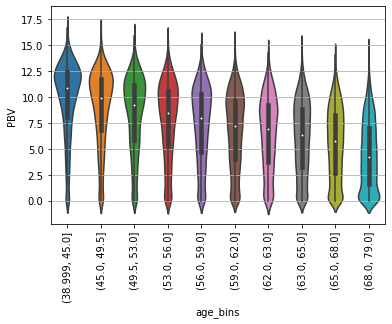

In [212]:
sns.violinplot(x='age_bins', y='PBV', data=df_agecorr)
plt.grid(axis='y')
plt.xticks(rotation=90);

## Assessment center effect
It would have been problematic if people in one assessment center have lower PBV without being older. At worst that would have implied some kind of batch effect, like that images were taken differently there. It could also have meant that people of different disease strata went there.

In [75]:
attendance_year=[int(i.year) for i in imgs['doa']];

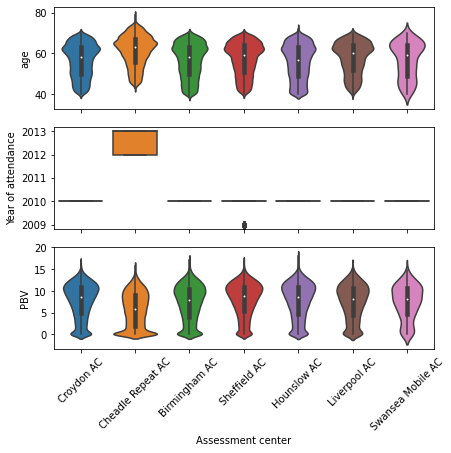

In [105]:
import seaborn as sns

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True, figsize=(6.4,6.4) )

sns.violinplot(x=imgs['ac'], y=imgs['age'], ax=ax1)
# ax1.set_xticks(rotation=45)
ax1.set(xlabel=None)

sns.violinplot(x=imgs['ac'], y=stats['PBV'], ax=ax3)
ax3.set(xlabel=None)

sns.boxplot(x=imgs['ac'], y=attendance_year, ax=ax2)
ax2.set(xlabel=None)
ax2.set_ylabel('Year of attendance')
ax2.set_yticks([2009,2010,2011,2012,2013])

plt.xticks(rotation=45)
plt.xlabel('Assessment center');

plt.tight_layout()

In [169]:
imgs['ac'].value_counts()
print("38351 imgs taken in Cheadle")

38351 imgs taken in Cheadle


In [171]:
tmp=imgs.loc[imgs['ac']=="Cheadle Repeat AC"]
cheadle_parts = list(set([i.split("_")[0] for i in tmp.index]))
print(len(cheadle_parts),"participants in cheadle")

19292 participants in cheadle


In [174]:
tmp=imgs.loc[(imgs['ac'] != "Cheadle Repeat AC")]
also_in_cheadle = [i for i in tmp.index if i.split("_")[0] in cheadle_parts]
print(len(also_in_cheadle), "images by participants who later went to cheadle")

4529 images by participants who later went to cheadle


In [180]:
print(len(set([i.split("_")[0] for i in list(also_in_cheadle)])), "parts who later went to Cheadle")

2276 parts who later went to Cheadle


In [175]:
tmp=list(also_in_cheadle)
print(len(set(cheadle_parts) - set([i.split("_")[0] for i in tmp])), "participants who went to Cheadle without previous assessment" )

17016 participants who went to Cheadle without previous assessment


In [181]:
print("-> While cheadle is a repeat AC, most people had their fundus images taken for the firt time there!")

-> While cheadle is a repeat AC, most people had their fundus images taken for the firt time there!


In [160]:
(tmp['ac'].value_counts())

Sheffield AC         2636
Liverpool AC         1869
Birmingham AC          12
Hounslow AC             6
Croydon AC              4
Swansea Mobile AC       2
Name: ac, dtype: int64

### One-way ANOVA

In [106]:
from scipy.stats import f_oneway

ac_anova = pd.DataFrame({'ac':imgs['ac'], 'age':imgs['age']}).dropna()
ac_anova.sort_values('ac', inplace=True)
out = ac_anova.groupby('ac')['age'].apply(list)

stat,anova_pval=f_oneway(out[0], out[1], out[2], out[3], out[4], out[5], out[6])

In [107]:

print("Age means differ btwn assessment centers, p =", anova_pval)

Age means differ btwn assessment centers, p = 0.0


## Diabetes prevalence and mean age by QC and sample size

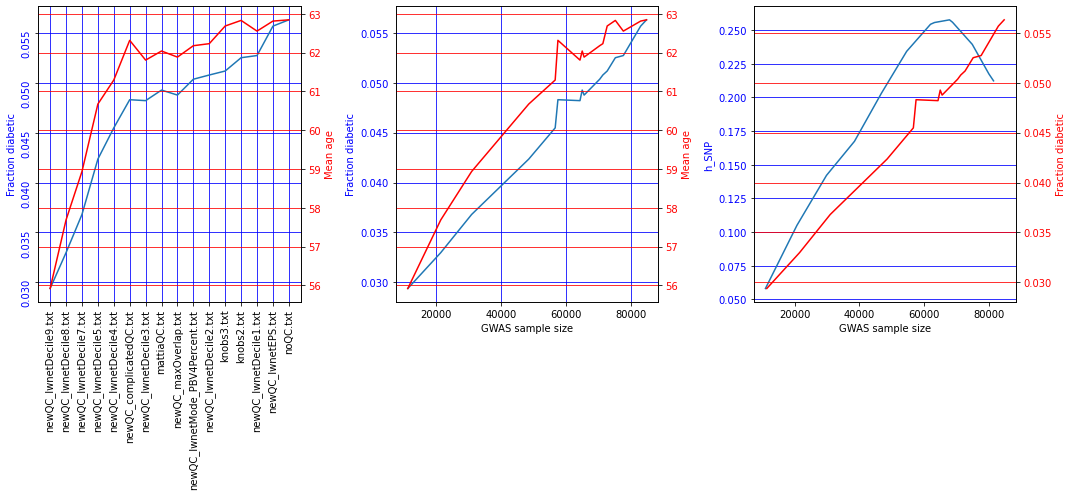

In [286]:
fig, (ax1,ax2, ax5) = plt.subplots(1,3,figsize=(15,7))


ax1.plot(qcs, fraction_diabetic);
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(labelrotation=90);
ax1.set_ylabel("Fraction diabetic", color='blue')
ax1.invert_xaxis()

ax3 = ax1.twinx()
ax3.plot(qcs, [2015-i for i in mean_age ], 'r')
ax3.tick_params(axis='y', labelcolor='red')
ax3.set_ylabel("Mean age", color='red')

ax1.grid(color='blue')
ax3.grid(color='red')


ax2.plot(Ns, fraction_diabetic);
ax2.tick_params(axis='y', labelcolor='blue')
# ax2.tick_params(labelrotation=90);
ax2.set_ylabel("Fraction diabetic", color='blue')
ax2.set_xlabel("GWAS sample size")


ax4 = ax2.twinx()
ax4.plot(Ns, [2015-i for i in mean_age ], 'r')
ax4.tick_params(axis='y', labelcolor='red')
ax4.set_ylabel("Mean age", color='red')

ax2.grid(color='blue')
ax4.grid(color='red')


ax5.plot(qc_results['N'].iloc[idx_lwnet],qc_results['h_SNP Full'].iloc[idx_lwnet])
ax5.set_ylabel("h_SNP", c='blue')
ax5.tick_params(axis='y', labelcolor='blue')
ax5.grid(axis='y',color='b')
ax5.set_xlabel("GWAS sample size")

ax6 = ax5.twinx()
ax6.plot(Ns, fraction_diabetic, color='r');
ax6.tick_params(axis='y', labelcolor='red')
ax6.set_ylabel("Fraction diabetic", c='red')
ax6.grid(axis='y',color='r')

plt.tight_layout()

The plots above show strong dependence of both age and the fraction of diabetics in our cohort on the sample size.

This is because people with low PBV are disproportionally older and diabetic, and thus get removed disproportionally as we increase the QC threshold.

However, this plot partially indicates that optimizing for h_SNP might not be problematic in our QC scheme.
Disease proportionality and mean age are not minimal at the location of maximal h_SNP. Rather, the global trend of reducing mean age and the fraction of diabetics in the remaining cohort is constant.
The locus of maximal h_SNP is at the location where the two main influences on h_SNP, (1) power and (2) noise are in balance.


**Remaining question**

Is it beneficial to make compromises in terms of h_SNP for gain of sample size?

# Age correction
Age being a major confounder for PBV, I am wondering if I can further improve the QC by correcting for it.

Improving means, improving max h_SNP.

Text(0.5, 0.98, 'PBV distribution before and after age correction')

<Figure size 345.6x576 with 0 Axes>

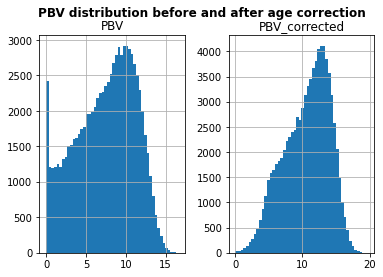

In [378]:
plt.figure(figsize=[4.8,8])
df_agecorr[['PBV', 'PBV_corrected']].hist(bins=50)
plt.suptitle("PBV distribution before and after age correction", fontweight='bold')

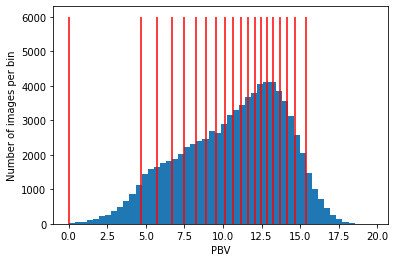

In [242]:
ventiles = [0] + list(np.quantile(df_agecorr['PBV_corrected'].dropna(), np.arange(1,20)/20))


# plt.figure(figsize=(12,8));
plt.hist(df_agecorr['PBV_corrected'], 50);
plt.xlabel('PBV')
plt.ylabel('Number of images per bin')

for i in ventiles:
    plt.vlines(i,0,6000,color='red')

In [392]:
# biases by QC, NOW FOR ALL QCS

with open(INDEXDIR+"noQC.txt", 'r') as f:
        tmp=[]
        for line in f:
            tmp.append(line.split("_")[0])
all_participants = set(tmp)

qcs = os.listdir(INDEXDIR)

qc_participants = []
for qc in qcs:
    with open(INDEXDIR+qc, 'r') as f:
        tmp=[]
        for line in f:
            tmp.append(line.split("_")[0])
    qc_participants.append(set(tmp))

sex_ratios = []
fraction_diabetic = []
fraction_heartAttack = []
fraction_stroke = []
age_diabetes_diagnosed = []
mean_age = []
Ns = []
for i,parts in enumerate(qc_participants):
    Ns.append(len(parts))

    tmp_df = labels.loc[[i for i in list(parts)]]
    tmp_throw = labels.loc[[ i for i in list (all_participants - parts) ]]
    tmp_df['QC'] = qcs[i]
    tmp_throw['QC'] = qcs[i]

    sex_ratios.append(tmp_df['sex'].mean())
    mean_age.append(tmp_df['year of birth'].mean())
    fraction_diabetic.append( 1 - tmp_df['age diabetes diagnosed'].isna().sum() / len(tmp_df) )
    fraction_heartAttack.append( 1 - tmp_df['age heart attack diagnosed'].isna().sum() / len(tmp_df) )
    fraction_stroke.append( 1 - tmp_df['age stroke diagnosed'].isna().sum() / len(tmp_df) )
    age_diabetes_diagnosed.append( tmp_df['age diabetes diagnosed'].mean() )

    if i == 0:
        labels_by_qc = tmp_df
        thrown_labels_by_qc = tmp_throw
        thrown_labels_by_qc = labels.loc[[i for i in list(all_participants)]]
        thrown_labels_by_qc['QC'] = "Base distribution"
        thrown_labels_by_qc = thrown_labels_by_qc.append(tmp_throw)
    else:
        labels_by_qc = labels_by_qc.append(tmp_df)
        thrown_labels_by_qc = thrown_labels_by_qc.append(tmp_throw)

ageBias_df=pd.DataFrame({'qc':qcs})
ageBias_df['sex ratios'] = sex_ratios
ageBias_df['mean year of birth'] = mean_age
ageBias_df['fraction diabetic'] = fraction_diabetic
ageBias_df['fraction heart attack'] = fraction_heartAttack
ageBias_df['fraction stroke'] = fraction_stroke
ageBias_df['age diabetes diagnosed'] = age_diabetes_diagnosed
ageBias_df['N'] = Ns
ageBias_df.set_index('qc', inplace=True)
ageCorrVentiles = ["ageCorrected_ventiles"+str(i)+".txt" for i in range(20)]


ValueError: Length of values (57) does not match length of index (17)

## h_SNP by QC with age correction

In [389]:
cutoffs = ['ventile0', 'ventile1', 'ventile10', 'ventile11','ventile12','ventile13','ventile14','ventile15','ventile16','ventile17','ventile18','ventile19','ventile2','ventile3','ventile4','ventile5','ventile6','ventile7','ventile8','ventile9']
N       = [81520,79337,49220,45081,40763,36419,31882,27176,22213,17122,11792,6178,77027,74368,71299,68022,64599,60909,57134,53194]
N_1perc = [76325, 73790, 44414, 40562, 36734, 32800, 28630, 24385, 19944, 15356, 10570, 5507, 71038, 68140, 65113, 61898, 58533, 55090, 51621, 48059]
hSNP    = [0.2125,0.2155,0.2061,0.1919,np.nan,0.1643,0.1488,0.1297,0.104,0.0815,0.0537,0.0336,0.2266,np.nan,0.2548,0.2603,0.2572,0.2467,0.2319,np.nan]
hSNP_1perc    = [0.2316,0.2493,0.1863,0.1807,0.1685,0.1512,0.1378,0.1136,0.0974,0.0768,0.0566,0.0288,0.2574,0.2614,0.26,0.252,0.2361,0.2253,0.2154,0.2022]

vent_df = pd.DataFrame({'cutoffs':cutoffs, 'N':N, 'hSNP':hSNP, 'N_1perc':N_1perc, 'hSNP_1perc':hSNP_1perc})

Text(0, 0.5, 'fraction diabetic')

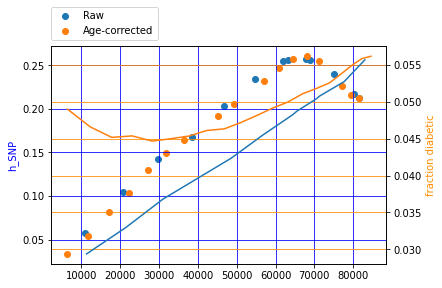

In [439]:
# plt.figure(figsize=(15,10))

f,ax=plt.subplots()

ax.scatter(qc_results['N'].iloc[idx_lwnet],qc_results['h_SNP Full'].iloc[idx_lwnet])

ax.scatter(vent_df['N'], vent_df['hSNP'])
ax.legend(['Raw', 'Age-corrected'], loc=(0,1.03))
ax.grid(color='blue')
ax.set_ylabel("h_SNP", color='blue')

ax2=ax.twinx()
initial_lwnet_qcs = [i for i in bias_df.index if "LWNET" in i]
ax2.plot(bias_df.loc[initial_lwnet_qcs, 'N'], bias_df.loc[initial_lwnet_qcs, 'fraction diabetic'])
ax2.plot(ageBias_df.loc[ageCorrVentiles, 'N'],ageBias_df.loc[ageCorrVentiles, 'fraction diabetic'])
ax2.grid(color='darkorange')
ax2.set_ylabel("fraction diabetic", color='darkorange')

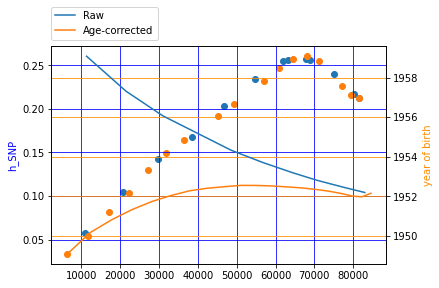

In [437]:
# plt.figure(figsize=(15,10))

f,ax=plt.subplots()

ax.scatter(qc_results['N'].iloc[idx_lwnet],qc_results['h_SNP Full'].iloc[idx_lwnet])

ax.scatter(vent_df['N'], vent_df['hSNP'])
ax.grid(color='blue')
ax.set_ylabel("h_SNP", color='blue')

ax2=ax.twinx()
initial_lwnet_qcs = [i for i in bias_df.index if "LWNET" in i]
ax2.plot(bias_df.loc[initial_lwnet_qcs, 'N'], bias_df.loc[initial_lwnet_qcs, 'mean year of birth'])
ax2.plot(ageBias_df.loc[ageCorrVentiles, 'N'],ageBias_df.loc[ageCorrVentiles, 'mean year of birth'])
ax2.grid(color='darkorange')
ax2.set_ylabel("year of birth", color='darkorange')

ax2.legend(['Raw', 'Age-corrected'], loc=(0,1.03))

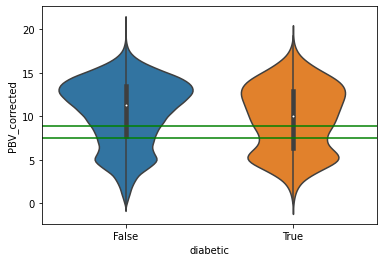

In [496]:
f=sns.violinplot(x=imgs['diabetic'], y=stats['PBV_corrected'])

f.axhline(ventile4, color='green')
f.axhline(ventile6, color='green')

While we can't improve maximal h_SNP much, the maximum is shifted a tad towards larger h_SNP.


More benefit might be for the deep learning projects, as we reduce age and diabetes bias for the range in which the QC is best

# END OF REPORT
# BEGINNING OF EXPLORATION

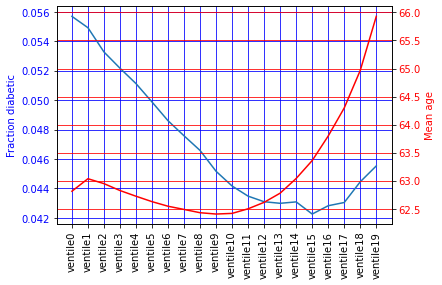

In [387]:
qcs = ['ventile'+str(i) for i in range(20)]

fig, ax1 = plt.subplots()
ax1.plot(qcs, fraction_diabetic);
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation='vertical');
ax1.set_ylabel("Fraction diabetic", color='blue')

ax2 = ax1.twinx()
ax2.plot(qcs, [2015-i for i in mean_age ], 'r')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel("Mean age", color='red')

ax1.grid(color='blue', )
ax2.grid(color='red')

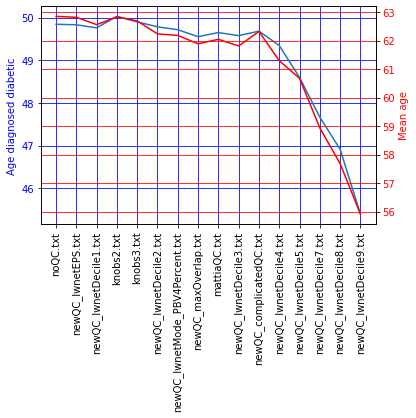

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(qcs, age_diabetes_diagnosed);
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation='vertical');
ax1.set_ylabel("Age diagnosed diabetic", color='blue')

ax2 = ax1.twinx()
ax2.plot(qcs, [2015-i for i in mean_age ], 'r')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel("Mean age", color='red')

ax1.grid(color='blue', )
ax2.grid(color='red')

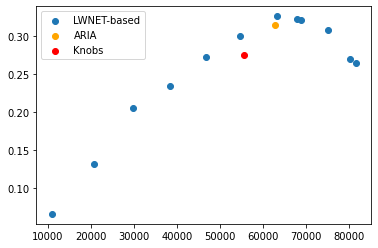

In [ ]:
qc_results=qc_results.sort_values("N", ascending=False)
idx_lwnet = [0,1,2,5,6,7,11,12,13,14,15,16]
mattia = 8
knobs = [3,4,10]
plt.scatter(qc_results['N'].iloc[idx_lwnet],qc_results['h_SNP Affymetrix'].iloc[idx_lwnet])
plt.scatter(qc_results['N'].iloc[mattia],qc_results['h_SNP Affymetrix'].iloc[mattia], c='orange')
plt.scatter(qc_results['N'].iloc[knobs],qc_results['h_SNP Affymetrix'].iloc[knobs], c='red')
plt.legend(['LWNET-based', "ARIA", "Knobs"])

Text(0.5, 1.0, 'Age distribution of participants with no images left for any given QC')

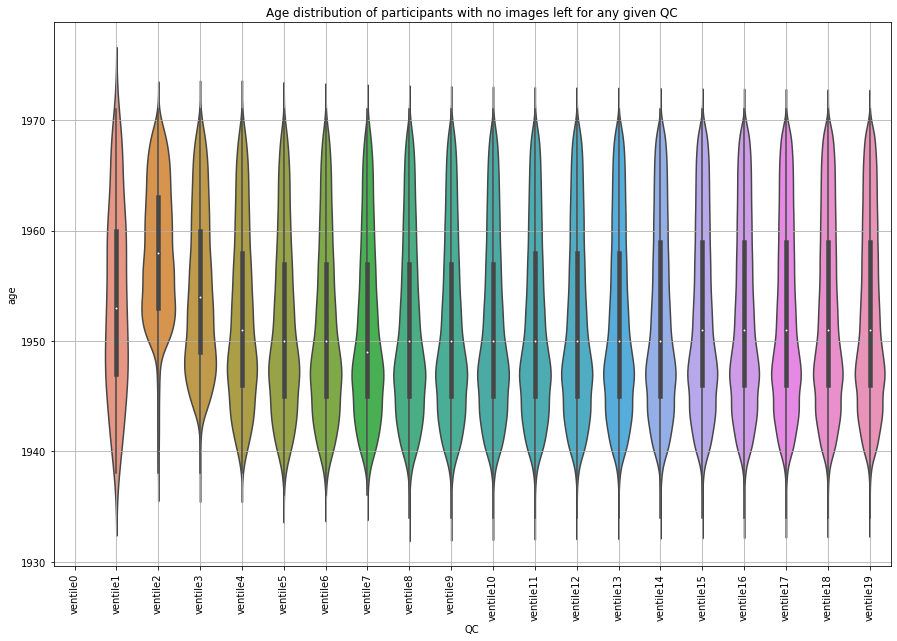

In [ ]:
# plot results

plt.figure(figsize=[15,10])
ax = sns.violinplot(x="QC", y="age", data=data_throw, order=qcs);
plt.grid()
plt.xticks(rotation=90);
plt.title("Age distribution of participants with no images left for any given QC")

(129193, 5)


array([[<AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'sdev'}>],
       [<AxesSubplot:title={'center':'blot_size'}>,
        <AxesSubplot:title={'center':'light_blot_size'}>],
       [<AxesSubplot:title={'center':'PBV'}>, <AxesSubplot:>]],
      dtype=object)

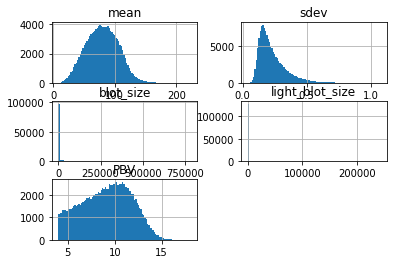

In [ ]:
explore = keep
explore=explore.sort_values("light_blot_size",ascending=False)
print(explore.shape)
explore.hist(bins=100)

0
mean                  206.372958
sdev                    0.198246
blot_size               0.000000
light_blot_size    242021.000000
PBV                     4.161778
Name: 2341259_21015_0_0.png, dtype: float64


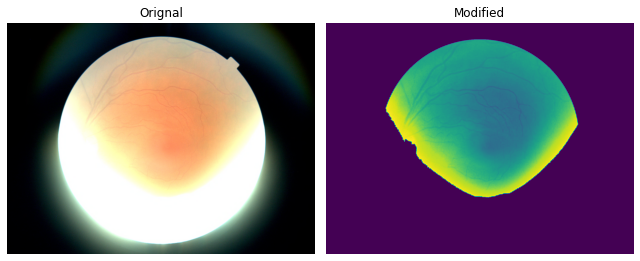

In [ ]:
i = 0
#i = "1035157_21015_0_0.png"
print(i)
#print(explore.loc[i])
print(explore.iloc[i])
#img = plt.imread(RAWDIR+i)
img=plt.imread(RAWDIR+explore.index[i])
width = img.shape[1]
height = img.shape[0]
new_size=(int(width*RESIZE_RADIUS/MASK_RADIUS), int(height*RESIZE_RADIUS/MASK_RADIUS))
img = cv2.resize(img, new_size)

gray = mask_image(img, toGray=True)
#gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
nGray = gray.copy()

#quantile = np.quantile(gray[gray.mask==False], BLOT_QUANTILE)
#print(quantile)

#nGray[nGray == 0] = 1
#plt.hist(nGray)
nGray[nGray.mask == True] = 1

nGray[(nGray>0.99) & (nGray.mask == False)] = 0

kernel = np.ones((3, 3), 'uint8')
dilate_img = cv2.erode(nGray, kernel, iterations=1)
view = dilate_img.copy()
view[view==0] = 0.3


#nGray[nGray==0] = 1
compare_image(img,view)

# #binary = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_BINARY)[1]
# binary = (dilate_img > 0).astype(np.uint8)
# binary = 1-binary
# connectivity = 4
# num_labels,labels,surfaceStats,centroids = cv2.connectedComponentsWithStats(binary, connectivity, cv2.CV_32S)

# print(np.max(surfaceStats[1:,4]))

In [ ]:
#binary = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_BINARY)[1]
binary = (dilate_img > 0).astype(np.uint8)
binary = 1-binary
connectivity = 4
num_labels,labels,surfaceStats,centroids = cv2.connectedComponentsWithStats(binary, connectivity, cv2.CV_32S)

In [ ]:
# cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_1bright/", throw_bright.index)
# cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_2highSD/", throw_sdev.index)
# cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_3blot/", throw_blots.index)
# cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_4lwnet/", throw_vasculature.index)
# cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_5lightblot/", throw_lightblots.index)
# cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/pass/", keep.index)

In [ ]:
with open("/HDD/data/UKBB/fundus/qcStats/knobs3.txt", 'w') as f:
    for i in keep.index:
        f.write(i+"\n")

In [ ]:
df_onlyMattia = stats.loc[only_mattiaQC]
df_onlyNew = stats.loc[only_newQC]
df_mattiaQD = stats.loc[mattiaQC_files]

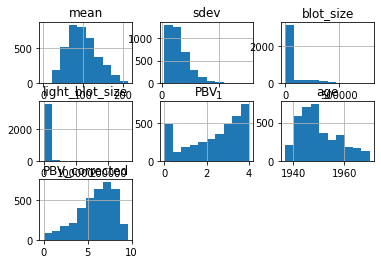

In [ ]:
df_onlyMattia.hist();

array([[<AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'sdev'}>,
        <AxesSubplot:title={'center':'blot_size'}>],
       [<AxesSubplot:title={'center':'light_blot_size'}>,
        <AxesSubplot:title={'center':'PBV'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'PBV_corrected'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

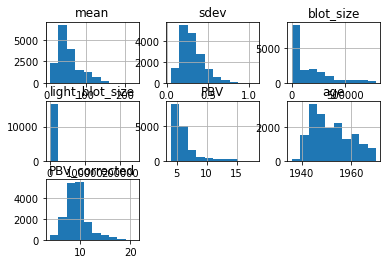

In [ ]:
df_onlyNew.hist()

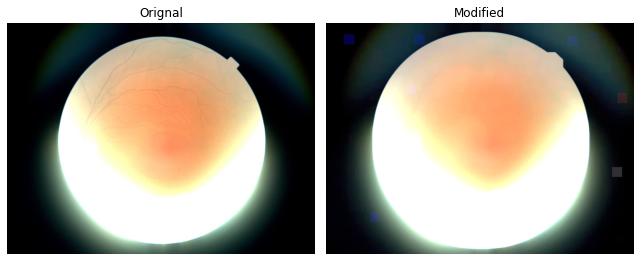

In [ ]:
kernel = np.ones((50,50),np.uint8)
dilation = cv2.dilate(img,kernel,iterations=1)
compare_image(img,dilation)


In [427]:
# stats = pd.DataFrame({'file':rawfiles, 'mean':np.nan,'stdev':np.nan,'blot_size':np.nan})

# for i,myf in enumerate(rawfiles[0:]):
#     img = plt.imread(RAWDIR+myf)
#     width = img.shape[1]
#     height = img.shape[0]
#     new_size=(int(width*RESIZE_RADIUS/MASK_RADIUS), int(height*RESIZE_RADIUS/MASK_RADIUS))
#     print(img.shape)
#     img = cv2.resize(img, new_size)
#     plt.imshow(img)
#     print(img.shape)
    
#     hh,ww=img.shape[:2]
#     #print(hh//2,ww//2)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     mask = np.zeros_like(gray)
#     mask = cv2.circle(mask, (ww//2,hh//2), RESIZE_RADIUS, (255,255,255), -1)
#     #mask = np.invert(mask.astype(bool))

#     #result = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
#     #result[:, :] = mask[:,:]
# #    result[:, :, 3] = mask[:,:,0]
#     #plt.imshow(result)
#     mskd_img=np.ma.array(gray, mask=np.invert(mask.astype(bool)))

#     stats['mean'].iloc[i]=mskd_img.mean()*255
#     stats['stdev'].iloc[i]=mskd_img.std()*255 / stats['mean'].iloc[i]
#     stats['blot_size'].iloc[i]=blot_size(img)

In [452]:
imgs.columns

Index(['instance', 'eid', 'ac', 'age', 'year of birth', 'doa', 'age_bins',
       'diabetic'],
      dtype='object')

In [466]:
tmp = imgs[imgs['diabetic']==True]
explore_df=stats.loc[tmp.index].sort_values("PBV", ascending=True)

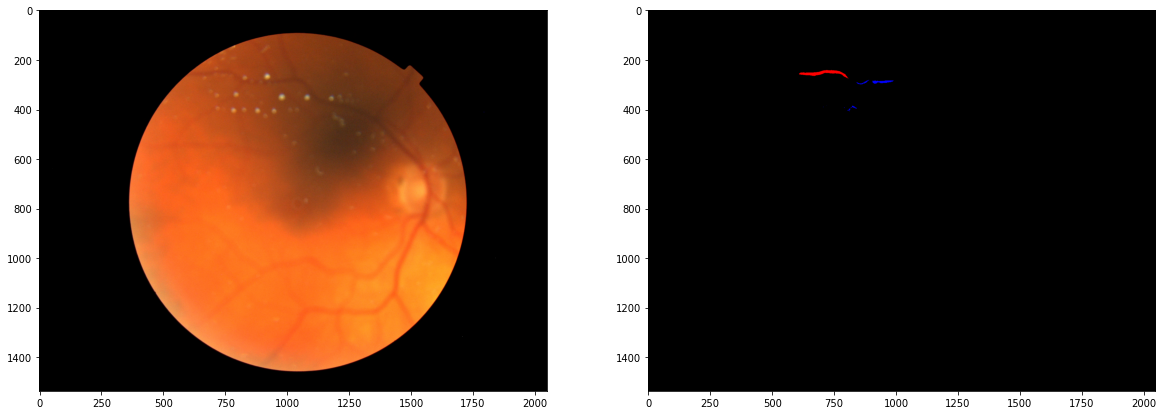

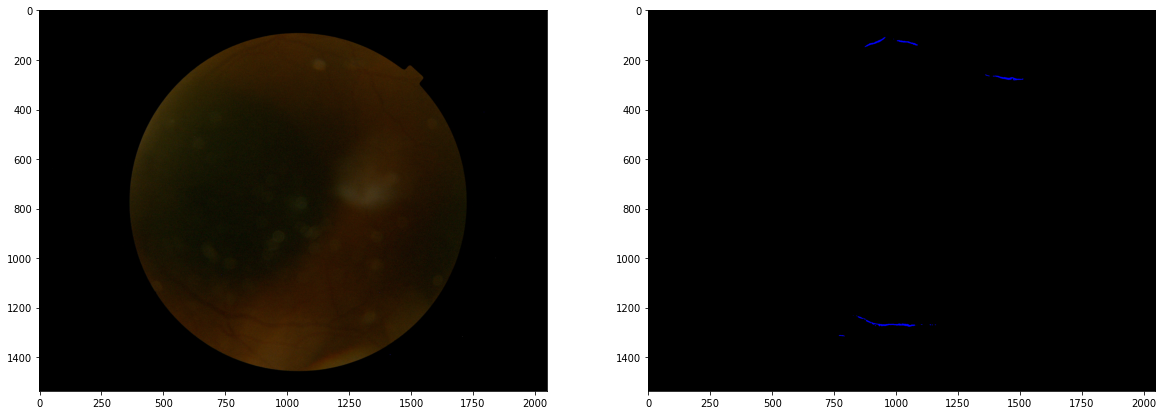

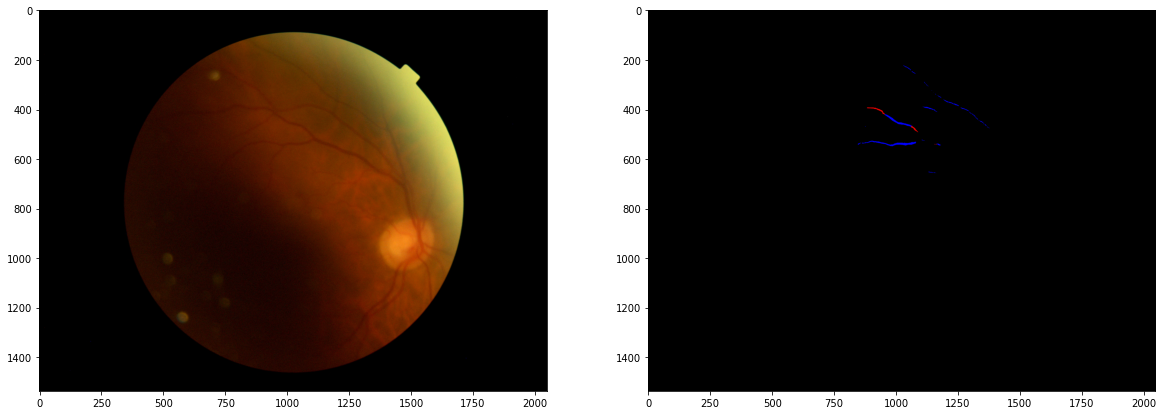

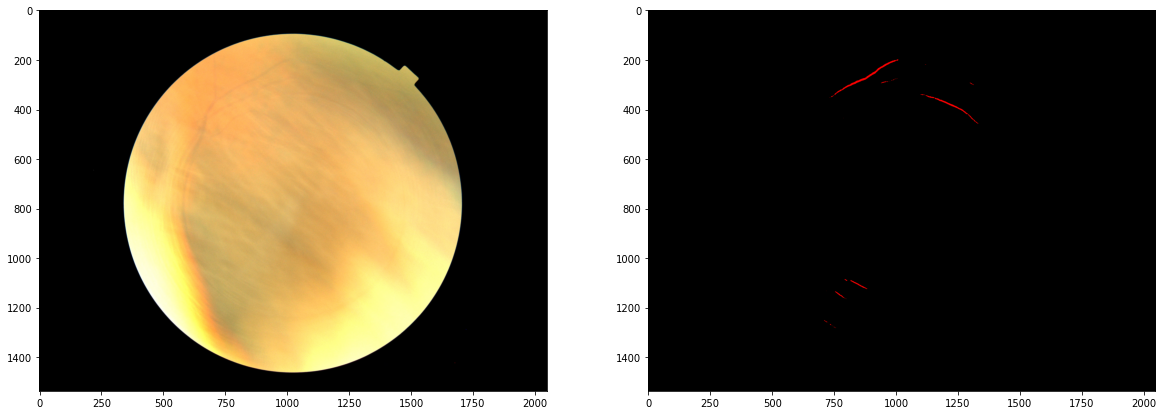

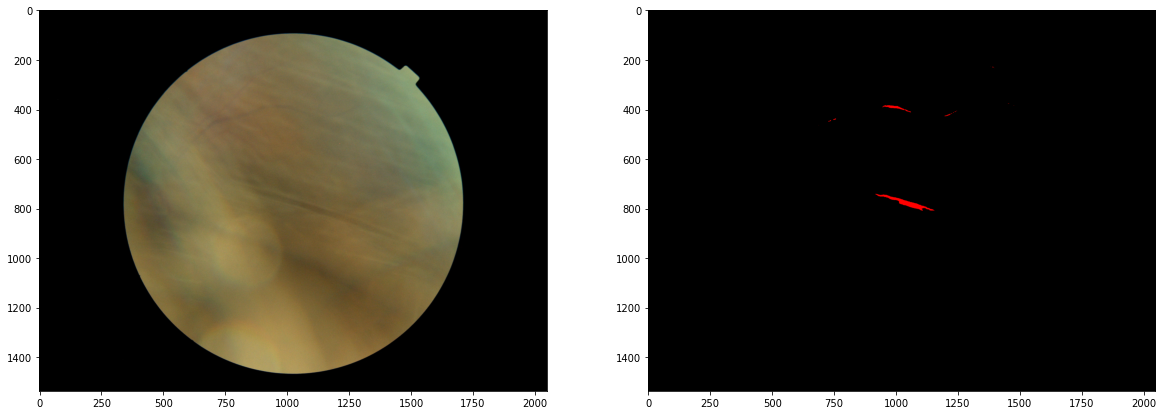

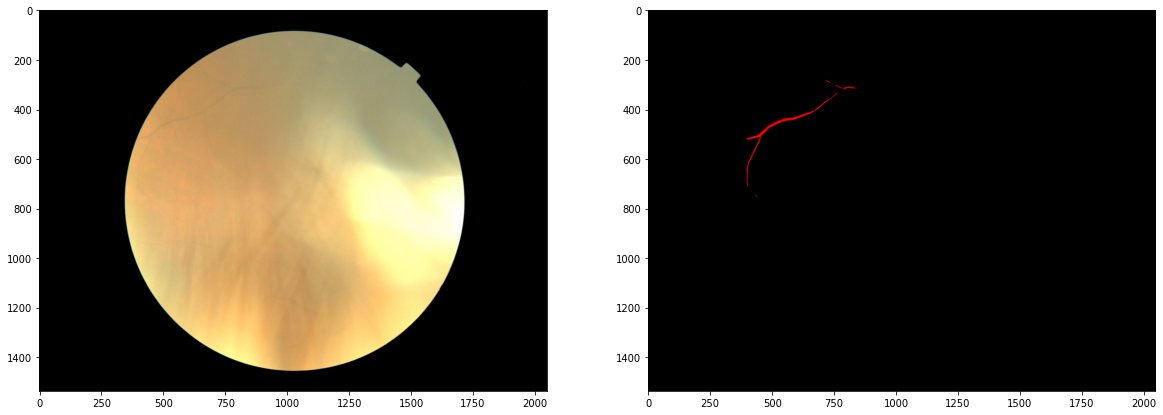

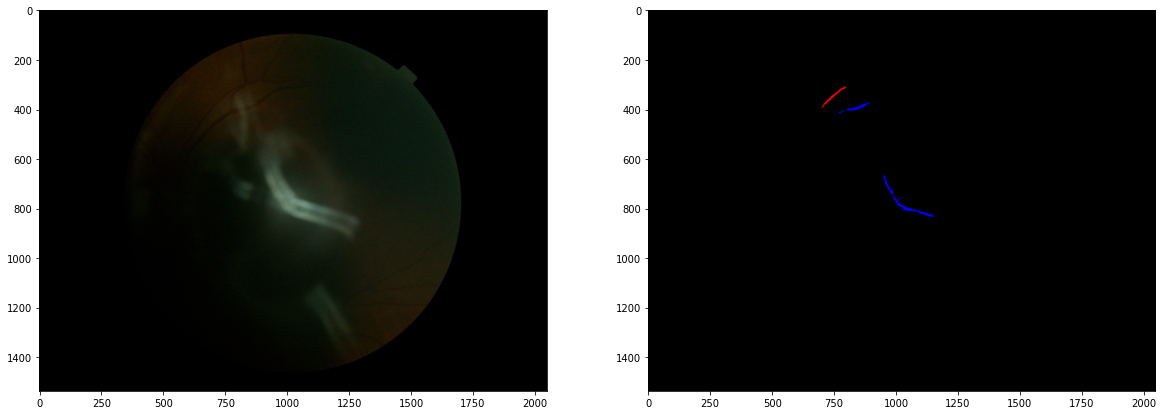

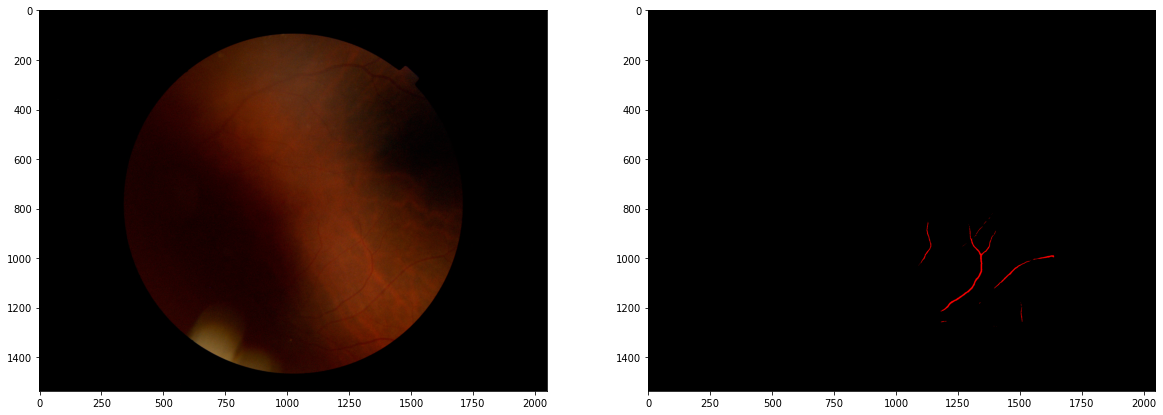

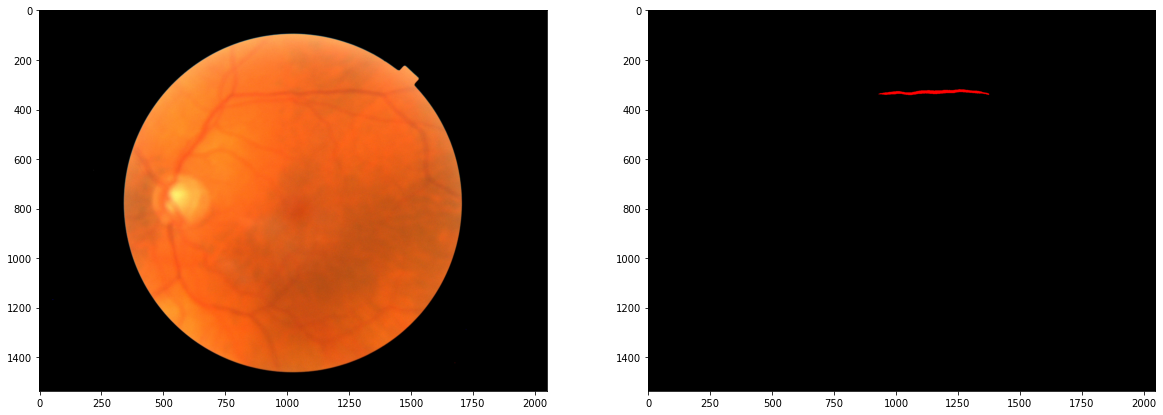

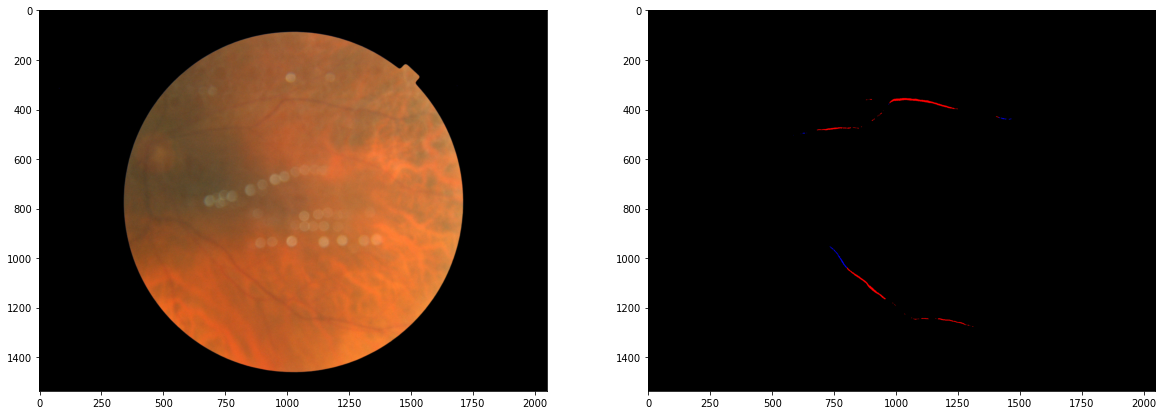

In [493]:
for k in range(10):
    i=i+15
    fileinfo(explore_df.index[i])

In [ ]:
plt.hist(stats['PBV'], 100);
for i in thresholds:
    plt.vlines(i,0,15000)

NameError: name 'plt' is not defined

In [ ]:
len(stats[stats['PBV']> thresholds[imax]])

117961